In [1]:
import sys
sys.path.append('/Users/Ziqi/Desktop/mgwr-master')
sys.path.append('/Users/Ziqi/Desktop/spglm')

from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

### 1. Load the dataset then convert it to Web Mercator projection (epsg=3857)

In [2]:
berlin = gpd.read_file("berlin-listings.geojson").to_crs(epsg=3857)

In [3]:
berlin.columns

Index(['id', 'last_scraped', 'name', 'house_rules', 'host_id', 'host_since',
       'host_is_superhost', 'instant_bookable', 'neighborhood', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities',
       'square_feet', 'price', 'minimum_nights', 'review_scores_rating',
       'geometry'],
      dtype='object')

### 2. Create a random sub-sample of the data with only complete records

In [4]:
subset = berlin[["price","review_scores_rating","accommodates","bathrooms","geometry"]]

subset = subset.dropna().sample(1000,random_state=1111)

### 3. Data preparation for MGWR
 - Dependent variable y (N,1)
 - Independent varibales X (N, p)
 - Coordinates of the locations (N, 2)
 - MGWR requires data to be standardised with mean of 0 and std of 1

In [5]:
subset['x'] = subset.geometry.x
subset['y'] = subset.geometry.y

In [6]:
y = subset['price'].values.reshape(-1,1)
X = subset[["review_scores_rating","accommodates","bathrooms"]].values

coords = list(zip(subset['x'],subset['y']))

In [7]:
y = (y - y.mean(axis=0))/y.std(axis=0)
X = (X - X.mean(axis=0))/X.std(axis=0)

### 4. Fitting a GWR model
- Step 1: Select the best bandwidth
- Step 2: Use the bandwidth to fit the model

In [8]:
gwr_selector = Sel_BW(coords,y,X)
gwr_bw = gwr_selector.search()
print("Optimal BW:", gwr_bw)

Optimal BW: 149.0


In [9]:
gwr_rslt = GWR(coords,y,X,gwr_bw).fit()

#### A summary of GWR results

In [10]:
gwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                1000
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            766.017
Log-likelihood:                                                   -1285.663
AIC:                                                               2579.326
AICc:                                                              2581.386
BIC:                                                               2598.957
R2:                                                                   0.234
Adj. R2:                                                              0.232

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5. Fitting an MGWR model
- Step 1: Select the best bandwidths
- Step 2: Use the bandwidths to fit the model

In [11]:
mgwr_selector = Sel_BW(coords,y,X,multi=True)
mgwr_bw = mgwr_selector.search()
print("Optimal BWs:",mgwr_bw)

Optimal BWs: [150. 999.  63. 162.]


In [12]:
mgwr_rslt = MGWR(coords,y,X,selector=mgwr_selector).fit()

In [13]:
mgwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                1000
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            766.017
Log-likelihood:                                                   -1285.663
AIC:                                                               2579.326
AICc:                                                              2581.386
BIC:                                                               2598.957
R2:                                                                   0.234
Adj. R2:                                                              0.232

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 6. Visualise MGWR results

`mgwr_rslt.params` returns the local coefficients (N, p+1)

In [14]:
mgwr_rslt.params

array([[ 0.05135395,  0.0376576 ,  0.36647036,  0.13354699],
       [ 0.04437837,  0.03553076,  0.80743243,  0.25685285],
       [ 0.6405602 ,  0.03613549,  0.55407096,  0.15681182],
       ...,
       [-0.17277999,  0.03946828,  0.6395406 , -0.03481376],
       [-0.17437668,  0.03894923,  0.24359593,  0.01210702],
       [ 0.04800376,  0.03768102,  0.79693242, -0.03350663]])

`mgwr_rslt.filter_tvals()` filters insignificant coefficients (p<0.05, after adjusting for multiple testing) as zeros.

In [15]:
mgwr_rslt.params[mgwr_rslt.filter_tvals() == 0] = np.nan

In [16]:
mgwr_rslt.params

array([[       nan,        nan,        nan,        nan],
       [       nan,        nan, 0.80743243,        nan],
       [0.6405602 ,        nan, 0.55407096,        nan],
       ...,
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan, 0.79693242,        nan]])

0

Mapping Local R2

NotImplementedError: Not yet implemented for multiple bandwidths

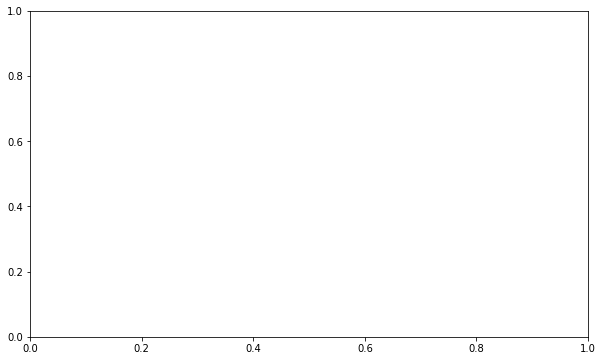

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(mgwr_rslt.localR2,legend=True,cmap="Reds",ax=ax)

Mapping local coefficients

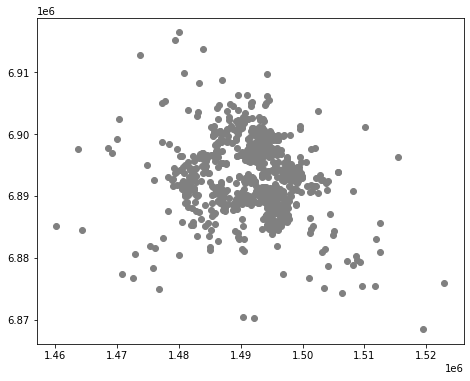

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
# Use grey to show locations with insignificant coefficients
subset.plot(color='grey',ax=ax)
# Plot significant local coefficients for X1
if np.sum(~np.isnan(mgwr_rslt.params[:,1])) > 0:
    subset.plot(mgwr_rslt.params[:,1],legend=True,cmap="bwr",ax=ax)

<AxesSubplot:>

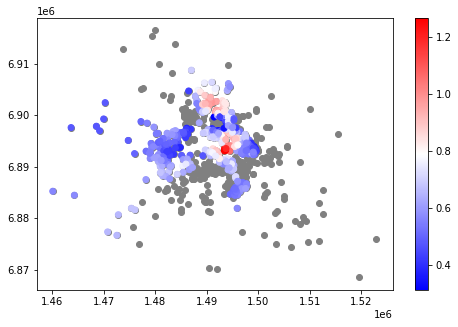

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax)

<AxesSubplot:>

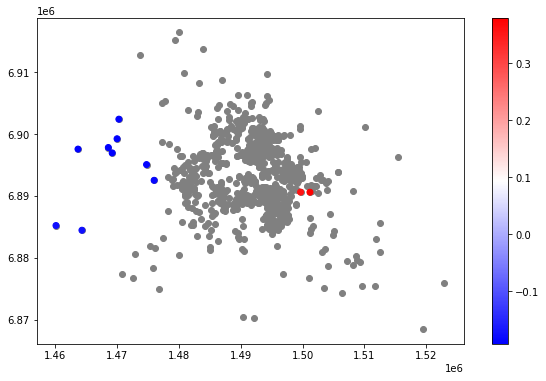

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,3],legend=True,cmap="bwr",ax=ax)

Add a basemap tile to provide a bit more context. An alternative option is to add an interactive basemap using `folium`.

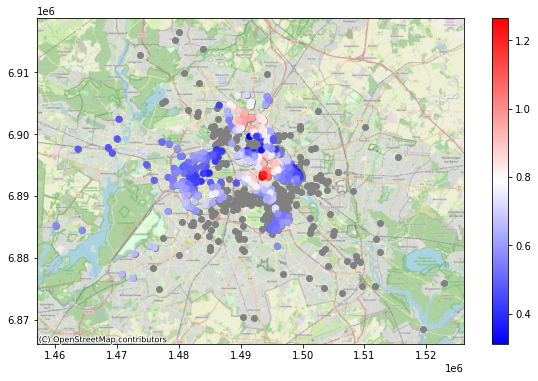

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='grey',ax=ax)
subset.plot(mgwr_rslt.params[:,2],legend=True,cmap="bwr",ax=ax)

#Add a basemap using contextuality package
cx.add_basemap(ax,source=cx.providers.OpenStreetMap.Mapnik)